In [1]:
# from https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html

import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path_pure = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path_pure):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path_pure.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        nb_path = nb_path_pure.replace("_", "-")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
sys.meta_path.append(NotebookFinder())

In [2]:
import numpy as np
import random
import torch
seed = 2023
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
from pegon_utils import CTCTrainer
from models import *
model = 'ctc-crnn-no-stretch-v2/2023-05-24 18:24:32.874318.pt'
model_path = os.path.join('/workspace/ctc-crnn/', model)
model_type = os.path.split(os.path.split(model_path)[0])[-1]
model = torch.load(model_path)

In [5]:
import torch.optim as optim
from pegon_utils import FocalCTCLoss

epochs = 25
optim = optim.AdamW(model.parameters(), lr=1e-3)
# optim = optim.AdamW(model.parameters(), lr=1e-4)
# criterion = FocalCTCLoss(zero_infinity=True, alpha=0.25, gamma=0.75)
criterion = None # default = nn.CTCLoss

model_finetune_path = model_path.replace('.pt', f'.annot.ft.{epochs}ep.pt')
train_plot_path = model_finetune_path.replace('.pt', '.train.png')
whole_eval_plot_path = model_finetune_path.replace('.pt', '.whole.wer-cer.png')
before_eval_plot_path = model_finetune_path.replace('.pt', '.before.wer-cer.png')
after_eval_plot_path = model_finetune_path.replace('.pt', '.after.wer-cer.png')

In [6]:
from pegon_utils import PegonAnnotatedDataset
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torch.utils.data import random_split, ConcatDataset

dataset_transforms = {'ctc-crnn':
                      transforms.Compose([
                          transforms.Grayscale(num_output_channels=1),
                          transforms.Resize((model.image_height, model.image_width)),
                          transforms.RandomHorizontalFlip(p=1),
                          transforms.ToTensor()]),
                      'ctc-ftex-rnn':
                      transforms.Compose([
                          transforms.Resize((model.image_height, model.image_width)),
                          transforms.RandomHorizontalFlip(p=1),
                          transforms.ToTensor()]),
                      'ctc-ftex-no-rnn':
                      transforms.Compose([
                          transforms.Resize((model.image_height, model.image_width)),
                          transforms.RandomHorizontalFlip(p=1),
                          transforms.ToTensor()]),
                      'ctc-crnn-no-stretch':
                      transforms.Compose([
                          transforms.Grayscale(num_output_channels=1),
                          ResizeAndPadHorizontal(target_h=model.image_height, target_w=model.image_width),
                          transforms.RandomHorizontalFlip(p=1),
                          transforms.ToTensor(),]),
                      'ctc-crnn-no-stretch-v2':
                      transforms.Compose([
                          transforms.Grayscale(num_output_channels=1),
                          ResizeAndPadHorizontal(target_h=model.image_height, target_w=model.image_width),
                          transforms.RandomHorizontalFlip(p=1),
                          transforms.ToTensor(),
                      ])}[model_type]

annotated_dataset = PegonAnnotatedDataset('/workspace/Dataset/pegon-annotated-dataset-split-v3',
                                          image_transform=dataset_transforms)

In [7]:
from pegon_utils import CTCDecoder, BestPathDecoder, evaluate, plot_cer_wer
from pegon_utils import PEGON_CHARS, CHAR_MAP
from pegon_utils import ctc_collate_fn

dataloader = DataLoader(annotated_dataset,
                        batch_size=4,
                        num_workers=2,
                        shuffle=True,
                        collate_fn=ctc_collate_fn)

decoder = BestPathDecoder.from_path(model_path, CHAR_MAP, blank_char=PEGON_CHARS[0])

cers, wers = evaluate(decoder, dataloader)

  0%|          | 0/1028 [00:00<?, ?it/s]

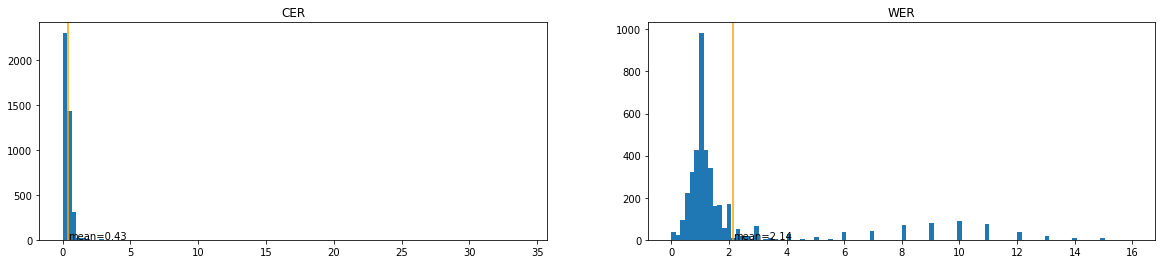

In [8]:
plot_cer_wer(cers, wers, path=whole_eval_plot_path)

In [9]:
train_dataset, val_dataset = random_split(annotated_dataset,
                                          lengths=[round(len(annotated_dataset) * frac) for frac in [0.5, 0.5]])

  0%|          | 0/514 [00:00<?, ?it/s]

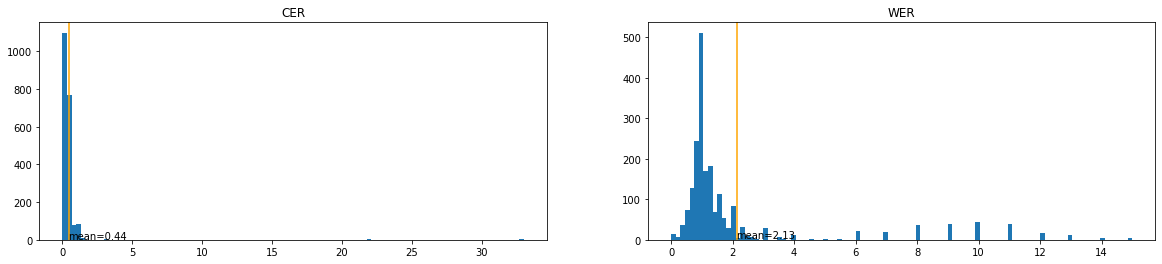

In [10]:
dataloader = DataLoader(val_dataset,
                        batch_size=4,
                        num_workers=2,
                        shuffle=True,
                        collate_fn=ctc_collate_fn)
cers, wers = evaluate(decoder, dataloader)
plot_cer_wer(cers, wers, path=before_eval_plot_path)

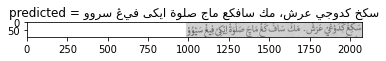

In [11]:
# demo

import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt

to_arabic_display = lambda text: get_display(arabic_reshaper.reshape(text))
img, label, _ = dataloader.collate_fn([random.choice(annotated_dataset)])

predicted = decoder.infer(img.cuda())[0]

tensor_to_display = lambda x : transforms.ToPILImage()(transforms.RandomHorizontalFlip(p=1)(x))

plt.imshow(tensor_to_display(img[0]),cmap='gray'); plt.title(f'predicted = {to_arabic_display(predicted)}'); plt.show()

In [12]:
trainer = CTCTrainer(model=model,
                     max_norm=None,
                     optimizer=optim,
                     batch_size=4,
                     num_workers=2,
#                      batch_size=16,
                     dataset=train_dataset,
                     criterion=criterion)

In [13]:
trainer.train(num_epochs=epochs, save_path=model_finetune_path)

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

Finished training! Took 0:07:46.696953.


CTCCRNNNoStretchV2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=352, out_features=16, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (lstm1): LSTM(16, 256, batch_first=True, bidirectional=True)
  (lstm2): LSTM(512, 128, batch_first=True, bidirectional=True)
  (fc2): Linear(in_features=256, out_features=80, bias=True)
)

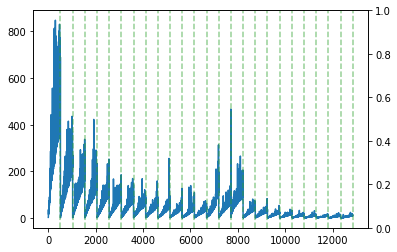

In [14]:
trainer.plot_history(train_plot_path)

In [15]:
decoder = BestPathDecoder(model, CHAR_MAP, blank_char=PEGON_CHARS[0])

cers, wers = evaluate(decoder, dataloader)

  0%|          | 0/514 [00:00<?, ?it/s]

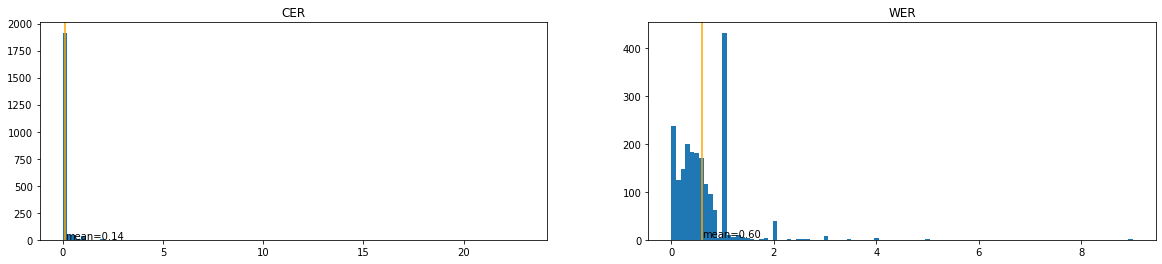

In [16]:
plot_cer_wer(cers, wers, path=after_eval_plot_path)

Prediction
ْفࣤرَاُكْيِااَوَهْيِفࣤراَكاَنَرࣤكْيَناَوَهْيِناَيَلْوُنْنَلاَْنُدْڠاَوْوُبُكْيِااَيِاْنَل
Ground truth
ْفࣤرَاُكْيِاَوَهْيَفࣤراَكاَنَرࣤكْيَناَوَهْيَناَيَلْوُنْنَلاَيْنُدْڠاَوْوُبُكْيِااَيِاْنَل


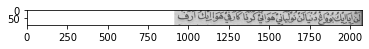

In [17]:
# demo

import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt

to_arabic_display = lambda text: get_display(text)
img, label = random.choice(val_dataset)
img, _, _ = dataloader.collate_fn([(img, label)])

predicted = decoder.infer(img.cuda())[0]
gt = ''.join([PEGON_CHARS[l] for l in filter(lambda x:x!= 0, label)])
print("Prediction")
print(to_arabic_display(predicted))
print("Ground truth")
print(to_arabic_display(gt))

tensor_to_display = lambda x : transforms.ToPILImage()(transforms.RandomHorizontalFlip(p=1)(x))

plt.imshow(tensor_to_display(img[0]),cmap='gray'); plt.show()